# This notebook has been modified to test a dataset that comprises 4 subpopulations

In [10]:
using DiffusionMLE, Plots

# Introduction

This is a minimal example on how to apply our maximum likelihood estimator to a set of heterogeneous single-particle tracking data.  Here, "heterogeneous" refers to the fact that the data originate from subpopulations with differing diffusion coefficients.  

The code relevant for the analysis of heterogeneous data exploits threading, so it is recommended to run the command <code>export JULIA_NUM_THREADS=n</code>, with <code>n</code> being the number of available (physical) cores, before launching Julia.  This speeds up the numerics significantly.  

For more details on the theoretical framework, please refer to the associated preprint:
> J. T. Bullerjahn and G. Hummer, "Maximum likelihood estimates of diffusion coefficients from single-molecule tracking experiments", https://arxiv.org/abs/2011.09955

# Generate trajectories

Each trajectory can be seen as a $d$-dimensional array (<code>Array{Float64,2}</code>), so the data set should be of the type <code>Array{Array{Float64,2},1}</code>.  

Here, we generate mock data, made up of $M$ $d$-dimensional trajectories of different lengths $N = \{N_{1}, N_{2}, \dots, N_{M}\}$.  The $N_{i}$ are distributed uniformly on the interval $[3,100]$.  The data form a $3:4:3$-mixture of trajectories generated using three distinct diffusive dynamics.  

In [11]:
include("smeared_trajectory_integrator.jl")

const M = 1000 # Number of trajectories
const d = 2 # Dimension of trajectories

const N_sub = 100 # Number of substeps over which the trajectory is smeared out

N = [ rand(3:100) for i = 1 : M ] # Array of trajectory lengths

# Consider three subpopulations, characterized by the following parameters:
const a2_1 = 0.5
const a2_2 = 2.0
const a2_3 = 1.0
const a2_4 = 3.0
const σ2_1 = 0.1
const σ2_2 = 1.0
const σ2_3 = 10.0
const σ2_4 = 50.0

B = [1/6 for m = 1 : M] # Array of blurring coefficients, where we have assumed a uniform illumination profile
data = vcat([make_2D_data(N[1:250],N_sub,a2_1,σ2_1), 
        make_2D_data(N[251:500],N_sub,a2_2,σ2_2), 
        make_2D_data(N[501:750],N_sub,a2_3,σ2_3),
        make_2D_data(N[751:1000],N_sub,a2_4,σ2_4),]...); # Mock data set

# Analyzing the data

In [12]:
function print_results(estimates,uncertainties)
    K = size(estimates,2)
    for k = 1 : K
        println(string("a2_", k, " = ", estimates[1,k], " ± ", uncertainties[1,k]))
    end
    for k = 1 : K
        println(string("σ2_", k, " = ", estimates[2,k], " ± ", uncertainties[2,k]))
    end
    for k = 1 : K
        println(string("P_", k, " = ", estimates[3,k]))
    end
end

const N_local = 500 # Max number of expectation-maximization cycles
const N_global = 100 # Number of iterations with different initial parameters

# Ranges from which the initial values for the parameters are drawn:
a2_range = [ 0.01, 100. ]
σ2_range = [ 0.01, 100. ];

### Available cores for threading

In [13]:
using Base.Threads
println(string("Number of available cores for threading: ", nthreads()))

Number of available cores for threading: 1


### Assuming a single population

Estimates:
a2_1 = 1.5133643122343372 ± 0.04554535798433486
σ2_1 = 15.557396009659689 ± 0.10960003172679672
P_1 = 1.0

Kuiper statistic:
κ = 28.220750628476114


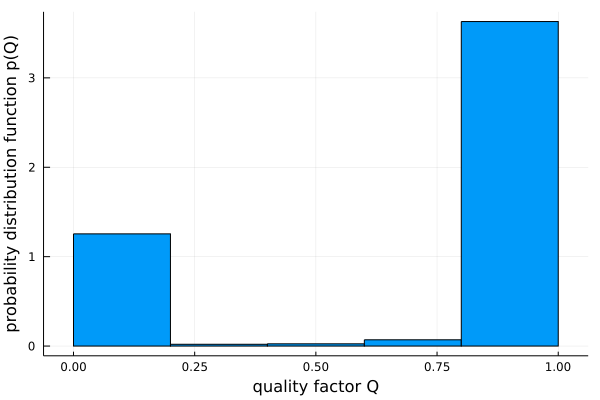

In [14]:
parameters = MLE_estimator(B,data)
parameter_matrix = reshape(vcat([parameters,[1.0]]...), 3, 1)
P1_estimates, P1_L, P1_T = local_EM_estimator!(d,M,1,N_local,parameter_matrix,B,data)
P1_uncertainties = MLE_errors(B,data,parameters)

println("Estimates:")
print_results(P1_estimates,P1_uncertainties)

Q_sub = subpopulation_analysis(P1_T,P1_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("κ = ",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false, 
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

The distribution of quality factors, which should be uniform, and the associated Kuiper statistic reveal that a single-population model does not suffice.  

### Assuming two subpopulations

In [15]:
P2_estimates, P2_L, P2_T = global_EM_estimator(2,N_local,N_global,a2_range,σ2_range,B,data);

Progress:  66%|████████████████████████████             |  ETA: 0:00:20┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


Estimates:
a2_1 = 1.27570157285365 ± 0.01263895417603421
a2_2 = 1.7683354490977856 ± 0.11115390833823802
σ2_1 = 0.5588366620479044 ± 0.008488830195566944
σ2_2 = 29.9078881830555 ± 0.2882014987158927
P_1 = 0.5020520132277053
P_2 = 0.49794798677229457

Kuiper statistic:
K=27.124034853864003


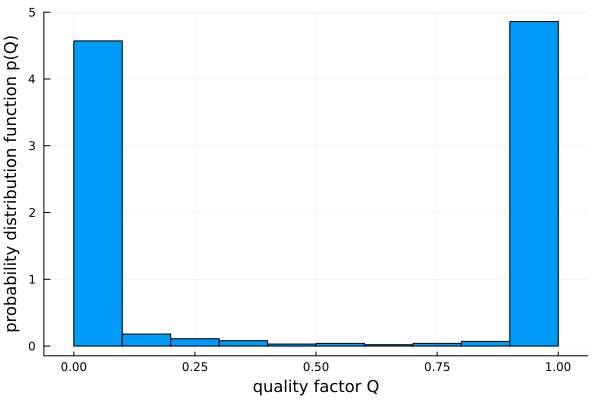

In [16]:
B_sub, X_sub = sort_trajectories(2,P2_T,B,data)
P2_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], P2_estimates[1:2,k]) for k = 1 : 2 ]...)

println("Estimates:")
print_results(P2_estimates,P2_uncertainties)

Q_sub = subpopulation_analysis(P2_T,P2_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false, bins=10,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

The Kuiper statistic is slightly better, but overall a two-population model cannot explain the data.  

### Assuming three subpopulations

In [17]:
P3_estimates, P3_L, P3_T = global_EM_estimator(3,N_local,N_global,a2_range,σ2_range,B,data);

Progress:  45%|███████████████████                      |  ETA: 0:00:46┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


Estimates:
a2_1 = 2.62761457107184 ± 0.2553383370909696
a2_2 = 0.48936303350115495 ± 0.0061016877980196475
a2_3 = 1.4433728439245819 ± 0.03169972948405775
σ2_1 = 49.48874201638935 ± 0.670325537037056
σ2_2 = 0.10308075869097107 ± 0.0026246803552972026
σ2_3 = 5.605050305795288 ± 0.059877861181214194
P_1 = 0.25579833774311184
P_2 = 0.24987112450727927
P_3 = 0.4943305377496089

Ground truth (up to permutations):
a2_1 = 0.5
a2_2 = 2.0
a2_3 = 1.0
σ2_1 = 0.1
σ2_2 = 1.0
σ2_3 = 10.0

Kuiper statistic:
K=11.96514283414219


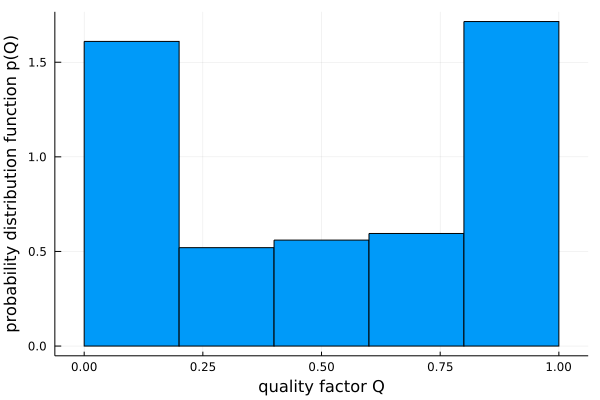

In [19]:
B_sub, X_sub = sort_trajectories(3,P3_T,B,data)
P3_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], P3_estimates[1:2,k]) for k = 1 : 3 ]...)

println("Estimates:")
print_results(P3_estimates,P3_uncertainties)

println()

println("Ground truth (up to permutations):")
println(string("a2_1 = ", a2_1))
println(string("a2_2 = ", a2_2))
println(string("a2_3 = ", a2_3))
println(string("σ2_1 = ", σ2_1))
println(string("σ2_2 = ", σ2_2))
println(string("σ2_3 = ", σ2_3))

Q_sub = subpopulation_analysis(P3_T,P3_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

### Assuming four subpopulations

In [20]:
P4_estimates, P4_L, P4_T = global_EM_estimator(4,N_local,N_global,a2_range,σ2_range,B,data);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:46


Estimates:
a2_1 = 2.6311000487087246 ± 0.2560907655523504
a2_2 = 2.0192171146798024 ± 0.02860582649708253
a2_3 = 0.4886927803728728 ± 0.006097091680627185
a2_4 = 0.9059186946474637 ± 0.05769038663369844
σ2_1 = 49.57802503350108 ± 0.672410812345699
σ2_2 = 0.9909199645971793 ± 0.020525636963383467
σ2_3 = 0.1030616851054037 ± 0.0026241709658297004
σ2_4 = 10.142929690010016 ± 0.14093424971101964
P_1 = 0.2522863641976156
P_2 = 0.25300675504622416
P_3 = 0.2479475111204361
P_4 = 0.24675936963572415

Ground truth (up to permutations):
a2_1 = 0.5
a2_2 = 2.0
a2_3 = 1.0
a2_4 = 3.0
σ2_1 = 0.1
σ2_2 = 1.0
σ2_3 = 10.0
σ2_4 = 50.0

Kuiper statistic:
K=1.4121246295566638


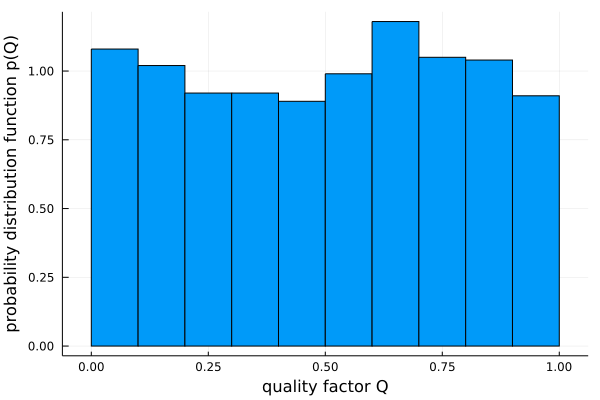

In [21]:
B_sub, X_sub = sort_trajectories(4,P4_T,B,data)
P4_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], P4_estimates[1:2,k]) for k = 1 : 4 ]...)

println("Estimates:")
print_results(P4_estimates,P4_uncertainties)

println()

println("Ground truth (up to permutations):")
println(string("a2_1 = ", a2_1))
println(string("a2_2 = ", a2_2))
println(string("a2_3 = ", a2_3))
println(string("a2_4 = ", a2_4))
println(string("σ2_1 = ", σ2_1))
println(string("σ2_2 = ", σ2_2))
println(string("σ2_3 = ", σ2_3))
println(string("σ2_4 = ", σ2_4))


Q_sub = subpopulation_analysis(P4_T,P4_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

The quality factors are uniformly distributed, and the Kuiper statistic evaluates close to unity for the three-population model.  

### Diffusion coefficients

Diffusion coefficients can be extracted from the $\sigma^2$-values, irrespective of the dimension $d$, as follows:
\begin{equation*}
D = \frac{\sigma^2}{2 \Delta t} \, .  
\end{equation*}
Here, $\sigma$ has the same dimension as the data, i.e., if the trajectories are recorded on the nanometer scale then $[\sigma] = \textrm{nm}$, and $\Delta t$ denotes the time step between two observations.  

In [22]:
data

1000-element Vector{Matrix{Float64}}:
 [0.16751792367611676 -0.9301851319165928; 0.5686314846720657 0.13002923191248872; … ; 0.9211978589880598 -1.4643654444436973; 0.07793230044680621 -1.406273327198444]
 [-0.5801158678927317 0.7702198408289577; 0.21289642800309994 0.0020618053136772507; … ; 2.2496855992854607 1.371952733425719; 2.528328388950977 2.9295529514931413]
 [0.42152791634000775 0.44696105032842387; 0.661889738406825 0.3653360066837323; … ; -1.7381833560638693 1.6361149706994578; -2.908651924712397 1.8489515168302046]
 [-0.3699652955527366 0.457051390426366; -0.2675661594540866 0.21320845875146657; … ; 4.0255824938417115 -0.08281059279692071; 2.6393047023802314 -0.15743840796108421]
 [0.16874225742393173 0.0921982946257782; -1.113739174664975 0.6153046327344585; … ; -0.24514224594303535 2.6900463232372993; -0.8560400893979991 3.0247094310490614]
 [-0.5305454047432934 -0.33057996555502994; -0.33481912570732864 0.08067073440275682; … ; 0.0875905479333422 -1.2479350538426135; 0.